### DGAN - `MNIST` dataset

In this notebook we are going to create a `DCGAN` model thatwill be able to generate mnist digit from random `latent_space` vector given.

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import datasets
import os
import matplotlib.pyplot as plt

### Loading the images
* Since this is unsupervised learning we are only interested in train images with no labels.

In [2]:
(train_images, _), test_example = datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### Displaying one example in the train examples.

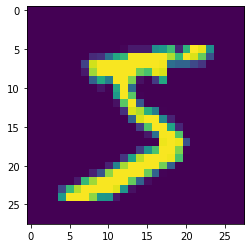

In [3]:
plt.imshow(train_images[0])

### Changing the datatype of each `pixel` to be of type `float32`.

In [4]:
train_images = train_images.astype('float32') 

### Normailizing images.
* reshape images to have an extra dim.
* scaling pixels to be between 0 and 1.

In [5]:
def normalize(image):
  image = tf.reshape(image, (28, 28, 1))
  return image/255

### Creating a dataset.

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices(train_images).map(normalize).batch(128).shuffle(6000)

### Displaying a single Example.

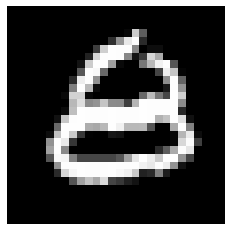

In [7]:
for x in train_ds:
    plt.axis("off")
    plt.imshow(x[0, :, :, 0], cmap="gray")
    break

In [8]:
x.shape

TensorShape([128, 28, 28, 1])

### Discriminator

In [9]:
discriminator = keras.Sequential([
    keras.layers.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", strides=(2, 2)),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, kernel_size=3, padding="same", strides=(2, 2)),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(512, kernel_size=3, padding="same", strides=(1, 1)),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", strides=(2, 2)),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dropout(.2),
    keras.layers.Dense(1, activation='sigmoid')
], name="discriminator")

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         147712    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 512)       

### Generator

In [10]:
latent_dim = 128

generator = keras.Sequential([
  keras.layers.Input(shape=(latent_dim, )),
  keras.layers.Dense(7*7*latent_dim, activation='relu'),
  keras.layers.Reshape((7, 7, latent_dim)),
  keras.layers.Conv2DTranspose(64, kernel_size=3, padding="same", strides=2),
  keras.layers.LeakyReLU(),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, kernel_size=3, padding="same", strides=1),
  keras.layers.LeakyReLU(),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2DTranspose(64, kernel_size=3, padding="same", strides=2),
  keras.layers.LeakyReLU(),
  keras.layers.BatchNormalization(),
  keras.layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')
], name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              809088    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        73792     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0 

### Overiding the `train_step`.

In [11]:
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.latent_dim = latent_dim

  # .compile()
  def compile(self, d_optimizer, g_optimizer, criterion):
    super(GAN, self).compile()
    self.criterion = criterion
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.d_loss_metric = keras.metrics.Mean(name="d_loss")
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  @property
  def metric(self):
    return [
       self.d_loss_metric,
       self.g_loss_metric     
    ]

  # .fit()
  def train_step(self, real_images):
    """
    Find the batch size of the images of each batch
    """
    batch_size = tf.shape(real_images)[0]
    """
    Create a latent_vector from random numbers of shape (batch_size, latent_dim)
    """
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    """
    Generate fake images by passing random_latent_vectors to the generator model.
    """
    generated_images = self.generator(random_latent_vectors)
    """
    Combine the generated and real images using the tf.cat()
    """
    combined_images = tf.concat([generated_images, real_images], axis=0)
    """
    Generate labels generated(ones) and real(zeros) and concate them
    """
    labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )
    """
    Add some noise to labels
    """
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    """
    Train the discriminator
    """
    with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.criterion(labels, predictions)
    """
    Calculate the gradients of the discriminator
    """        
    gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(gradients, self.discriminator.trainable_weights )
    )
    """
    Regenerate the latent_vectors for the generators and create misleading 
    labels and train the generator.
    """
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))
    with tf.GradientTape() as tape:
        predictions = self.discriminator(self.generator(random_latent_vectors))
        g_loss = self.criterion(misleading_labels, predictions)
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    # Update metrics
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    """
    RETURM METRICS AS A DICTIONARY.
    """
    return {
        "d_loss": self.d_loss_metric.result(),
        "g_loss": self.g_loss_metric.result(),
    }

### Trainning Callbacks.

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))
model_path = "best_model.h5"
checkpoint = keras.callbacks.ModelCheckpoint(model_path, 
                             monitor= "g_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = keras.callbacks.EarlyStopping(monitor= "g_loss", 
                      mode= "auto", 
                      patience = 5)

### End to end model training

In [18]:
epochs = 100  # In practice, use ~100 epochs
gan = GAN(discriminator, 
          generator, 
          latent_dim
          )
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    criterion=keras.losses.BinaryCrossentropy(from_logits=False),
    # metrics=["acc"]
)
gan.fit(
    train_ds, epochs=epochs, callbacks=[GANMonitor(num_img=4, latent_dim=latent_dim), early]
)

Epoch 1/100
469/469 [==============================] - 58s 115ms/step - d_loss: 0.5246 - g_loss: 1.4282
Epoch 2/100
469/469 [==============================] - 56s 116ms/step - d_loss: 0.5105 - g_loss: 1.5832
Epoch 3/100
469/469 [==============================] - 56s 116ms/step - d_loss: 0.4996 - g_loss: 1.4260
Epoch 4/100
469/469 [==============================] - 56s 116ms/step - d_loss: 0.5008 - g_loss: 1.5047
Epoch 5/100
469/469 [==============================] - 56s 116ms/step - d_loss: 0.5010 - g_loss: 1.4774
Epoch 6/100
469/469 [==============================] - 56s 116ms/step - d_loss: 0.4991 - g_loss: 1.4924
Epoch 7/100
469/469 [==============================] - 56s 116ms/step - d_loss: 0.4979 - g_loss: 1.5478
Epoch 8/100
469/469 [==============================] - 56s 115ms/step - d_loss: 0.4998 - g_loss: 1.4384


### Generating images.

In [36]:
generated_images_from_model = gan.generator(tf.random.normal(shape=(15, 128)))

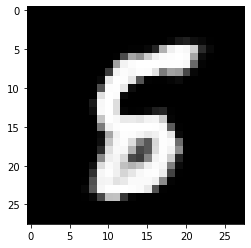

In [37]:
plt.imshow(generated_images_from_model[0][:, :, 0], cmap='gray')

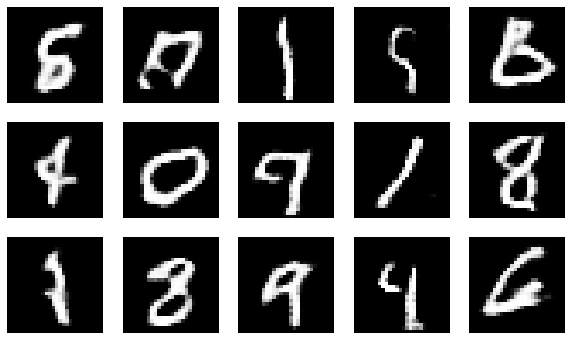

In [38]:
def plot_images(images, cols=5):
  rows = 3
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, image in enumerate(images):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image[:, :, 0], cmap="gray")
plot_images(generated_images_from_model)
plt.show()